<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.-Upsampling" data-toc-modified-id="1.-Upsampling-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>1. Upsampling</a></span></li><li><span><a href="#2.-Downsampling" data-toc-modified-id="2.-Downsampling-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>2. Downsampling</a></span></li><li><span><a href="#3.-SMOTE-(рассмотренный-вне-теории-самостоятельно)" data-toc-modified-id="3.-SMOTE-(рассмотренный-вне-теории-самостоятельно)-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>3. SMOTE (рассмотренный вне теории самостоятельно)</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# Врагу не сдается наш гордый варяг ))
#!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Здесь будут функции

def split(data, test_size, random_state):
    # разбиваем с проверкой и стандартизацией
    
    # разобьем выборку на трэйн-тест
    X_train, X_test, y_train, y_test = train_test_split(data.drop('exited', axis=1),
                                                        data['exited'],
                                                        test_size=test_size,
                                                        random_state=random_state)
    
    # scaler
    numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', ]
    scaler = MinMaxScaler()
    X_train[numeric] = scaler.fit_transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])
    
    # проверка
    print("Получили данные в следующей пропорции:")
    print(round(100*X_train.shape[0]/data.shape[0],0), ":",
          round(100*X_test.shape[0]/data.shape[0],0))

    return X_train, X_test, y_train, y_test

def upsample(features, target):
    # добавляем признаков с единицами в трэйн выборку
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_ones_upsample = features_ones.sample(features_zeros.shape[0], replace=True)
    target_ones_upsample = target_ones.sample(target_zeros.shape[0], replace=True)

    features_upsampled = pd.concat([features_zeros] + [features_ones_upsample])
    target_upsampled = pd.concat([target_zeros] + [target_ones_upsample])
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

def downsample(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(features_ones.shape[0], random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(target_ones.shape[0], random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [4]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('Churn.csv')

data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


**Признаки**  
- RowNumber — индекс строки в данных  
- CustomerId — уникальный идентификатор клиента  
- Surname — фамилия  
- CreditScore — кредитный рейтинг  
- Geography — страна проживания  
- Gender — пол  
- Age — возраст  
- Tenure — сколько лет человек является клиентом банка  
- Balance — баланс на счёте  
- NumOfProducts — количество продуктов банка, используемых клиентом  
- HasCrCard — наличие кредитной карты  
- IsActiveMember — активность клиента  
- EstimatedSalary — предполагаемая зарплата  

**Целевой признак**  
- Exited — факт ухода клиента

In [5]:
# Видим, что первых три столбца не несут в себе нужной для модели информации. Но перед удалением посмотрим, нет ли дубликатов
print(data['RowNumber'].duplicated().sum())
print(data['CustomerId'].duplicated().sum())

0
0


In [6]:
#уберем ненужные признаки
data.drop(['RowNumber',	'CustomerId', 'Surname'], axis=1, inplace=True)

In [7]:
# переведем кэмелкейс названия столбцов в снэйккейс
data.columns = ['credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

In [8]:
# Посмотрим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


видим, что в признаке tenure есть пропуски (меньше 10%), а так же он излишне float.  
Какого то разумного объяснения как получились эти пропуски - нет, скорее всего какой то технический сбой.  
Скорее всего они "пропали" при скачивании на платформу яндекса c Kaggle (вот только случайно или нет - остаётся загадкой)  
Количество признаков небольшое, посмотрим на баланс целевой переменной (в целом по датасету и по пропущенным значениям)

In [9]:
print('значения целевой переменной в общем датасете', '\n', data['exited'].value_counts(), sep='')
print('-'*50)
print('значения целевой переменной в пропусках tenure', '\n', data[data['tenure'].isna()]['exited'].value_counts(), sep='')

значения целевой переменной в общем датасете
0    7963
1    2037
Name: exited, dtype: int64
--------------------------------------------------
значения целевой переменной в пропусках tenure
0    726
1    183
Name: exited, dtype: int64


Видим что наш датасет несбалансирован по целевой переменной. Но в пропусках такой "небаланс" сохраняется. Поэтому удалим пропуски.

In [10]:
data = data[~data['tenure'].isna()]

In [11]:
# И приведем этот признак к типу int
data['tenure'] = data['tenure'].astype(int)

Два категориальных признака (тип object) переведем: gender - к булеву типу, второй - применим one-hot-encoding  
Только сначала посмотрим, что дисбаланса признаков - нет 

In [12]:
data['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

In [13]:
data['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

Есть небольшой перекос в сторону Франции.

In [14]:
data['gender'] = data['gender'].map({'Female': 0, 'Male':1})
data = pd.get_dummies(data=data, columns=['geography'], drop_first=True)

In [15]:
# Так же проверим на дубликаты
data.duplicated().sum()

0

In [16]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       9091 non-null   int64  
 1   gender             9091 non-null   int64  
 2   age                9091 non-null   int64  
 3   tenure             9091 non-null   int64  
 4   balance            9091 non-null   float64
 5   num_of_products    9091 non-null   int64  
 6   has_cr_card        9091 non-null   int64  
 7   is_active_member   9091 non-null   int64  
 8   estimated_salary   9091 non-null   float64
 9   exited             9091 non-null   int64  
 10  geography_Germany  9091 non-null   uint8  
 11  geography_Spain    9091 non-null   uint8  
dtypes: float64(2), int64(8), uint8(2)
memory usage: 799.0 KB


Собственно - подготовили данные для дальнейшего исследования.  
Удалили пропуски, ненужные признаки, проверили на сбалансированность и дубликаты.  
В принципе задача глубокого EDA не стоит, и датасет готов к построению моделей ML 

In [17]:
data.sample(3)

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain
6017,487,0,34,2,96019.5,1,0,0,9085.00,0,0,0
9190,646,0,46,8,0.0,2,1,0,133059.15,0,0,0
3368,630,1,67,5,0.0,2,1,1,27330.27,0,0,0


## Исследование задачи

In [18]:
# разобьем данные на трэйн-тест
X_train, X_test, y_train, y_test = split(data, test_size=0.2, random_state=12345)

Получили данные в следующей пропорции:
80.0 : 20.0


для подбора гиперпараметров воспользуемся GridSearchCV  (непонятно почему нам его так и не дали в теории)  
Выведем на экран лучшие гиперпараметры, и лучшую точность при подборе параметров.

In [19]:
%%time

# 1. Классификатор по градиентному бустингу
gbc = GradientBoostingClassifier(random_state=666)

param_grid = {'learning_rate':[0.01, 0.1],
              'n_estimators':[x for x in range(70,91,20)],
              'max_depth':[x for x in range(4,7)],
              'min_samples_split':[x for x in range(2,4)],
              'min_samples_leaf':[4,5],
              'subsample':[0.6, 0.8],
              }

grid_search_gbc = GridSearchCV(gbc, param_grid, scoring = 'f1', n_jobs=-1, cv=5)
grid_search_gbc.fit(X_train, y_train)

print(grid_search_gbc.best_params_)
print(grid_search_gbc.best_score_)

{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 70, 'subsample': 0.8}
0.5983211242133251
CPU times: user 6min 30s, sys: 1.1 s, total: 6min 32s
Wall time: 6min 32s


In [20]:
%%time

# 2. Случайный лес
rfr = RandomForestClassifier(random_state=666)

param_grid = {'n_estimators':[100, 200],
              'criterion':['gini', 'entropy'],
              'max_depth':[x for x in range(9,13,3)],
              'min_samples_split':[x for x in range(2,4)],
              'min_samples_leaf':[x for x in range(3,7,3)],
              }

grid_search_rfr = GridSearchCV(rfr, param_grid, scoring = 'f1', n_jobs=-1, cv=5)
grid_search_rfr.fit(X_train, y_train)

print(grid_search_rfr.best_params_)
print(grid_search_rfr.best_score_)

{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
0.5723053009900163
CPU times: user 2min 39s, sys: 804 ms, total: 2min 40s
Wall time: 2min 40s


In [21]:
%%time

# 3. Логистическая регрессия
lr = LogisticRegression(class_weight='balanced', random_state=666)

param_grid = {'penalty':['l1', 'l2'],
              'C': [0.25, 0.5],
              'fit_intercept':[True, False],
              'solver':['lbfgs', 'newton-cg'],
              'multi_class':['auto', 'multinomial'],
              'max_iter':[100, 500]
              }

grid_search_lr = GridSearchCV(lr, param_grid, scoring = 'f1', n_jobs=-1, cv=5)
grid_search_lr.fit(X_train, y_train)

print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)

{'C': 0.25, 'fit_intercept': True, 'max_iter': 100, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
0.49465479405794444
CPU times: user 18.3 s, sys: 23.2 s, total: 41.5 s
Wall time: 41.5 s


In [22]:
%%time

# 4. Дерево решений
dtc = DecisionTreeClassifier(random_state=666)

param_grid = {'criterion':['gini', 'entropy'],
              'splitter':['best', 'random'],
              'max_depth':[x for x in range(3,10)],
              'min_samples_split':[x for x in range(2,6)],
              'min_samples_leaf':[x for x in range(3,10,3)],
              }

grid_search_dtc = GridSearchCV(dtc, param_grid, scoring = 'f1', n_jobs=-1, cv=5)
grid_search_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
print(grid_search_dtc.best_score_)

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'best'}
0.5687502957809313
CPU times: user 27.5 s, sys: 102 ms, total: 27.6 s
Wall time: 27.7 s


Итак, лучше всего себя в этой задаче показал градиентный бустинг. Подставим в него лучшие подобранные параметры и проверим на тестовой выборке.


In [23]:
%%time

gbc = GradientBoostingClassifier(**grid_search_gbc.best_params_, random_state=666)

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
f1_score(y_test, y_pred)

CPU times: user 1.14 s, sys: 11.3 ms, total: 1.15 s
Wall time: 1.15 s


0.5987055016181231

Собственно, условия задачи выполнены ))) f1 > 0.59. Можно сдавать проект )))

## Борьба с дисбалансом


#### 1. Upsampling

_Примечание для себя. Вобщем я сначала, как умный Вася, взял всю выборку, продублировал фичи с единицами (сбалансировал), потом разбил на трэйн тест и удивился, как круто у меня f1 получился 0,84 (круче первого места на Каггле ). Потом дошло - что предсказания идут уже по выученным моделью примерам... Нельзя так )))_

In [24]:
# Добавим признаков несбалансированного класса
X_train_upsample, y_train_upsample = upsample(X_train, y_train)

In [25]:
# Обучим модель на обогащенных за счет upsampling данных
gbc.fit(X_train_upsample, y_train_upsample)

# предскажем и выведем f1
y_pred = gbc.predict(X_test)
f1_score(y_test, y_pred)

0.5983701979045402

Теперь похоже на правду. f1 подняли почти на 0.014... (На моей локальной машине результат был намного хуже)

#### 2. Downsampling

In [26]:
# Уберем признаки несбалансированного класса
X_train_downsample, y_train_downsample = downsample(X_train, y_train)

In [27]:
%%time

# Обучим модель на обогащенных за счет downsampling данных
gbc.fit(X_train_downsample, y_train_downsample)

# предскажем и выведем f1
y_pred = gbc.predict(X_test)
f1_score(y_test, y_pred)

CPU times: user 614 ms, sys: 3.57 ms, total: 618 ms
Wall time: 631 ms


0.5965270684371807

Хм, результат стал хуже (на локальной хоть и незначительно но улучшился)

#### 3. SMOTE (рассмотренный вне теории самостоятельно)

In [28]:
# Врагу не сдается наш гордый варяг ))
# pip install imbalanced-learn

In [29]:
smote = SMOTE(sampling_strategy='minority', random_state=666)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# проверка
y_train_sm.value_counts()

0    5787
1    5787
Name: exited, dtype: int64

In [30]:
%%time

# Обучим модель на обогащенных за счет downsampling данных
gbc.fit(X_train_sm, y_train_sm)

# предскажем и выведем f1
y_pred = gbc.predict(X_test)
f1_score(y_test, y_pred)

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.08 s


0.6239782016348775

Вот. Что и требовалось доказать. Нормальные инструменты в теории Яндекса не дают. Приходится "ковырять" самому.
Добавили к f1 примерно 0.03, если пользоваться только данной теорией.

## Тестирование модели

AUC-ROC: 0.8580244836931127


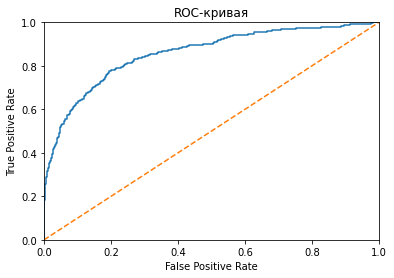

In [31]:
# возьмем вероятности отнесения к одному или другому классу
probabilities_valid = gbc.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

# Посчитаем ROC-AUC
print('AUC-ROC:', roc_auc_score(y_test, probabilities_one_valid))

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

# построим график
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# применим функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate"
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title()
plt.title('ROC-кривая')
plt.show();

Построили рок-кривую, на которой наглядно видно, что наша модель существенно лучше случайной

#### Выводы

- Загрузили и подготовили данные.  
Удалили пропуски, ненужные признаки, проверили на сбалансированность и дубликаты. Предполагаю, что пропуски сделаны яндексом специально, чтобы датасет отличался от представленного на Каггле. Т.о. считаем, что пропуски получены из-за системной, а не человеческой ошибки.  
Пропусков немного (меньше 10%), поэтому принял решение их удалить, на сбалансированнойсть выборки это не повлияло. Можно было заполнить пропуски данными с Каггла )).    
Аномальных значений в признаках нет.  
- Было протестировано 4 модели на несбалансированной выборке.  
GradientBoostingClassifier, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier. Подобрали для них оптимальные гиперпараметры. Лучшим себя показал Граддиентный бустинг. В дальнейшей работе использовал его с оптимальными параметрами.  
- Исследовали баланс классов.
Применили три метода для балансировки. Upsampling, Downsampling и метод SMOTE. Последний показал себя наилучшим образом, улучши модель (f1 увеличили на 0.03).
- Построили ROC-кривую, для наглядности. Наглядно видно, что наша модель существенно лучше рандомной модели.

Рекомендации. Опыт Каггла показывает, что для получения более высоких результатов целесообразно использовать DL (keras и сверточные слои), но будем считать, что мы до них пока еще не доросли